In [2]:
# dev
import sys
sys.path.append("..")

import pyparanoid.pyparanoid as pp
import pyparanoid.genomeplot as gplot

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
### This analysis takes a set of strains and identifies genes unique to each strain.

### Here's a text file with a PyParanoid strain name on each line

!head ../src/comparison_strains.txt


pseudomonas_brassicacearum_subsp_brassicacearum_nfm421
pseudomonas_sp_wcs365
pseudomonas_sp_pseudo5_n2c3
pseudomonas_sp_pseudo6_fw300_n2e2
pseudomonas_fluorescens_f113


In [5]:
### Store the strain names as an array

strains = [line.rstrip() for line in open("../src/comparison_strains.txt",'r').readlines()]

In [6]:
### Get genome-wide presence/absence data from the PyParanoid database
### Stores info as a numpy matrix with PyParanoid groups as rows and
### individual strains as columns.

### also returns a list of PyParanoid groups

mat, groups = gplot.subset_matrix(strains,"../../data/Pseudo")
mat.shape

(24066, 5)

In [7]:
### You can use numpy methods to get some info about these strains.
### For example, calculate a genome similarity metric by taking the
### Pearson correlation coefficient between strains.

cc = np.corrcoef(mat.T)

### You can use the dump_matrix() function to save this info in a 
### tab delimited text file.

gplot.dump_matrix(cc,strains,"../src/corrcoef.txt")

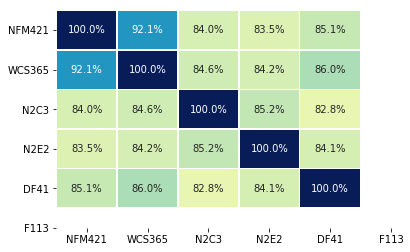

In [8]:
### And then you can use seaborn to plot the info
### Note that the matrix is ordered on both axes based on the
### order in the "strains" array.

labels = ["NFM421","WCS365","N2C3","N2E2","DF41","F113"]
sns.heatmap(cc, annot=True,vmin=0.80,vmax=1,linewidths=.5,
            xticklabels=labels,fmt=".1%",yticklabels=labels,cmap="YlGnBu",cbar=False)
plt.show()

In [9]:
### Iterate through the matrix and find genes which are unique 
### to each strain or uniquely missing from each strain.

### Use the strains array and the numpy matrix from subset_matrix*()

uniq_info = gplot.find_unique_genes(mat, strains,groups)


pseudomonas_brassicacearum_subsp_brassicacearum_nfm421
	200 unique
	35 missing
pseudomonas_sp_wcs365
	84 unique
	59 missing
pseudomonas_sp_pseudo5_n2c3
	310 unique
	149 missing
pseudomonas_sp_pseudo6_fw300_n2e2
	303 unique
	135 missing
pseudomonas_fluorescens_f113
	289 unique
	139 missing
4396 common to all strains.


In [10]:
### This "uniq_info" object is a python dict of dicts with info about all the
### unique or missing genes in the analysis.

uniq_info.keys()

['unique', 'common', 'missing']

In [11]:
### uniq_info["unique"] and uniq_info["missing"] are dicts keyed by 
### strain names containing lists of the relevant groups

for x in uniq_info["unique"]["pseudomonas_sp_pseudo5_n2c3"][0:5]:
    print x

print "\n"

### uniq_info["common"] contains a list because they are shared by all strains.

for y in uniq_info["common"][0:5]:
    print y

group_02644
group_02827
group_02958
group_03010
group_03220


group_00002
group_00004
group_00005
group_00006
group_00007


In [12]:
#### focusing in on P. brassicacearum
## what are the names of the loci uniquely found in this strain?

unique_loci = gplot.find_unique_loci("pseudomonas_sp_pseudo5_n2c3","../../data/Pseudo",uniq_info)

print unique_loci[0:10]


['Pseudo5_05527', 'Pseudo5_05960', 'Pseudo5_03318', 'Pseudo5_02274', 'Pseudo5_05360', 'Pseudo5_05361', 'Pseudo5_04773', 'Pseudo5_01534', 'Pseudo5_03324', 'Pseudo5_01533']


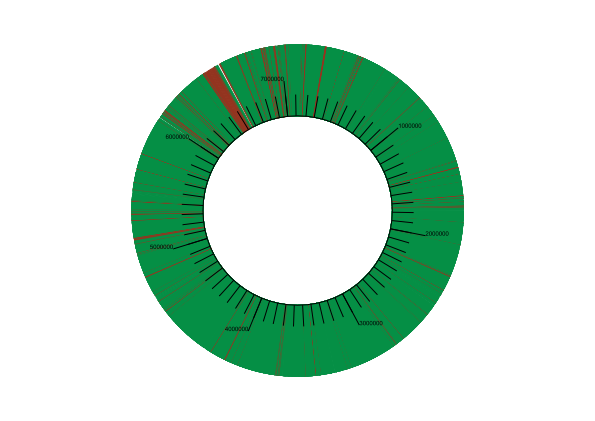

In [13]:
### if you have a Genbank file with the same locus tags as used for PyParanoid,
### you can use the plot_unique_genome_diagram() function to show the location of these genes.

### This probably only works for circular, finished genomes...

gdd = gplot.plot_unique_genome_diagram("../../data/genomedb/gbk/pseudomonas_sp_pseudo5_n2c3.gbk", unique_loci)

### This returns a GenomeDiagram object from Biopython.
### To export to a file for viewing.

gdd.write('N2C3_unique.png', 'png')
from IPython.display import Image
Image(filename='N2C3_unique.png')


In [14]:
### As you can see from this diagram, bacterial genes tend to be gained and lost in "chunks".
### Thus, an easy way to identify genomic insertions is to check out chromosomal synteny.

### Use synteny_check() to map locus tags for your set of strains to one specific genbank file.
### In this example, you need the genbank file, the PyParanoid database, the strain the genbank is from,
### the strains array and a destination to write the output to.

gplot.synteny_check("../../data/genomedb/gbk/pseudomonas_sp_pseudo5_n2c3.gbk","../../data/Pseudo/",\
                   "pseudomonas_sp_pseudo5_n2c3",strains,"../src/synteny.txt")